In [37]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [2]:
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
                                    root="../data", train=True,
                                    transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
                                    root="../data", train=False,transform=trans, download=True)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
def get_fashion_mnist_labels(labels): #@save
    """Return text labels for the Fashion-MNIST dataset."""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
    'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5): #@save
    """Plot a list of images."""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # Tensor Image
            ax.imshow(img.numpy())
        else:
            # PIL Image
            ax.imshow(img)
            ax.axes.get_xaxis().set_visible(False)
            ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

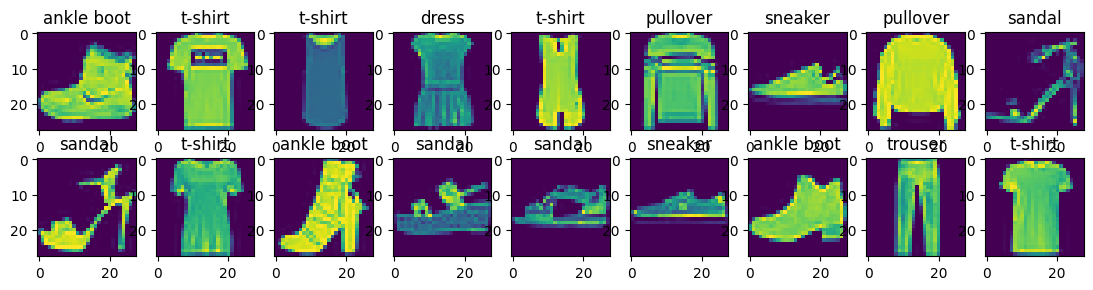

In [7]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [8]:
# Reading minibatch
batch_size = 256
def get_dataloader_workers(): #@save
    """Use 4 processes to read the data."""
    return 4
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers())

In [9]:
import time

start_timer = time.time()
for X, y in train_iter:
    continue
end_timer = time.time()
print(f"Time_taken: {end_timer-start_timer:.2f} sec")

Time_taken: 0.87 sec


In [10]:
def load_data_fashion_mnist(batch_size, resize=None): #@save
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
                                                root="../data", train=True,
                                                transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
                                                root="../data", train=False,
                                                transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
            num_workers=get_dataloader_workers()))

In [11]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


### SoftMax Regression

In [12]:
batch_size = 256
train_iter, test_iter = load_data_fashion_mnist(batch_size)

#### Model

In [13]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

In [14]:
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition # The broadcasting mechanism is applied here

In [15]:
X = torch.normal(0, 1, (2, 5))
X_prob = softmax(X)
X_prob, X_prob.sum(1)

(tensor([[0.0614, 0.1481, 0.0919, 0.3350, 0.3635],
         [0.4335, 0.0498, 0.2805, 0.1837, 0.0525]]),
 tensor([1.0000, 1.0000]))

In [16]:
# Model
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

Below is using tensor slicing smartly instead of using for loop, we can get y_hat of correct class.

In [17]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]])
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [18]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])
cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

In [19]:
def accuracy(y_hat, y): #@save
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [20]:
class Accumulator: #@save
    """For accumulating sums over `n` variables."""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)
        
    def __getitem__(self, idx):
        return self.data[idx]

In [21]:
def evaluate_accuracy(net, data_iter): #@save
    """Compute the accuracy for a model on a dataset."""
    if isinstance(net, torch.nn.Module):
        net.eval() # Set the model to evaluation mode
    metric = Accumulator(2) # No. of correct predictions, no. of predictions
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [22]:
evaluate_accuracy(net, test_iter)

0.0926

In [23]:
def train_epoch_ch3(net, train_iter, loss, updater): #@save
    """The training loop defined in Chapter 3."""
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

In [24]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater): #@save
    """Train a model (defined in Chapter 3)."""
    train_loss = []
    train_acc = []
    test_accuracy = []

    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        train_loss.append(train_metrics[0])
        train_acc.append(train_metrics[1])
        test_accuracy.append(test_acc)
        print(f"Epoch {epoch + 1}, Train Loss: {train_metrics[0]}, Train Accuracy: {train_metrics[1]}, Test Accuracy:{test_acc}")
    return train_loss, train_acc, test_accuracy
    

In [25]:
def sgd(params, lr, batch_size): #@save
    """Minibatch stochastic gradient descent."""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [26]:
lr = 0.1
def updater(batch_size):
    return sgd([W, b], lr, batch_size)

In [27]:
num_epochs = 10
metrics = train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

Epoch 1, Train Loss: 0.7863344144821167, Train Accuracy: 0.7498333333333334, Test Accuracy:0.7934
Epoch 2, Train Loss: 0.5712248477300008, Train Accuracy: 0.8132, Test Accuracy:0.8052
Epoch 3, Train Loss: 0.5259664951960246, Train Accuracy: 0.8253333333333334, Test Accuracy:0.8167
Epoch 4, Train Loss: 0.5016673931757609, Train Accuracy: 0.8314666666666667, Test Accuracy:0.7963
Epoch 5, Train Loss: 0.4858433613459269, Train Accuracy: 0.8363833333333334, Test Accuracy:0.8261
Epoch 6, Train Loss: 0.47451040706634523, Train Accuracy: 0.8387333333333333, Test Accuracy:0.8276
Epoch 7, Train Loss: 0.465164542833964, Train Accuracy: 0.8420666666666666, Test Accuracy:0.8317
Epoch 8, Train Loss: 0.4581970096588135, Train Accuracy: 0.8451333333333333, Test Accuracy:0.8326
Epoch 9, Train Loss: 0.451990460395813, Train Accuracy: 0.8468, Test Accuracy:0.8259
Epoch 10, Train Loss: 0.4471182717005412, Train Accuracy: 0.8486833333333333, Test Accuracy:0.8272


In [28]:
import seaborn as sns

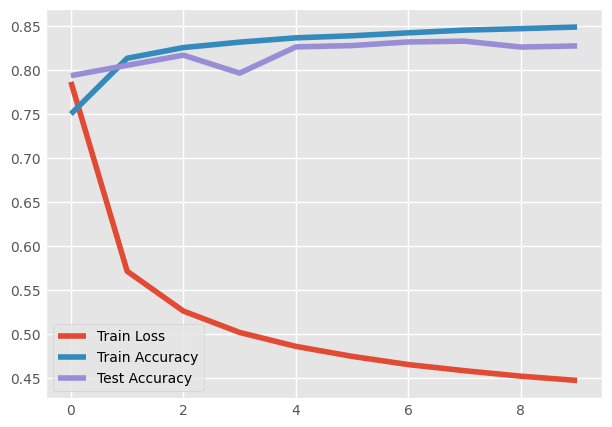

In [39]:
sns.lineplot(metrics[0], label = "Train Loss")
sns.lineplot(metrics[1], label = "Train Accuracy")
sns.lineplot(metrics[2],label = "Test Accuracy")
plt.show()